# Poisoning Attack

In [1]:
# Download ART
!pip install adversarial-robustness-toolbox

     |████████████████████████████████| 890kB 5.5MB/s 
     |████████████████████████████████| 21.0MB 1.4MB/s 
     |████████████████████████████████| 235kB 36.3MB/s 
     |████████████████████████████████| 747kB 39.9MB/s 


(1797, 64) (1797,)


<Figure size 432x288 with 0 Axes>

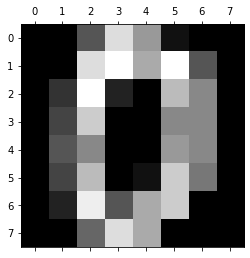

In [2]:
import numpy as np
from sklearn.datasets import load_digits
digits = load_digits()

print(digits.data.shape, digits.target.shape)
import matplotlib.pyplot as plt 
plt.gray()
plt.matshow(digits.images[0])
plt.show()

In [3]:
from sklearn.model_selection import train_test_split
X = digits.data
y = digits.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
nb_classes = np.unique(y_train).shape[0]
print(np.unique(y_train))
print(X_train.shape, X_test.shape)

[0 1 2 3 4 5 6 7 8 9]
(1437, 64) (360, 64)


In [4]:
from sklearn.svm import SVC

def evaluateModel(model, X_test, y_test):
    predictions = model.predict(X_test)
    accuracy = np.sum(predictions == y_test) / len(y_test)
    return accuracy

# Create the model
model = SVC(C=1.0, kernel="rbf").fit(X_train, y_train)

# Evaluate the SVM classifier on benign test examples
accuracy = evaluateModel(model, X_test, y_test)
print("Accuracy on benign test examples: {:.2f}%".format(accuracy * 100))

Accuracy on benign test examples: 98.61%


### Backdoor Attack (black box)

paper: https://arxiv.org/abs/1708.06733

ART github source code: https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/art/attacks/poisoning/backdoor_attack.py

blog post to learn about this: https://towardsdatascience.com/poisoning-attacks-on-machine-learning-1ff247c254db

In [5]:
from art.attacks.poisoning import PoisoningAttackBackdoor
from art.attacks.poisoning.perturbations import image_perturbations

In [13]:
# Use Backdoor poisonining attack on training data
# Using "add_single_bd" as perturbation function; could try others or a list of perturbations
backdoor_attack = PoisoningAttackBackdoor(perturbation=image_perturbations.add_pattern_bd)
X_train_p, y_train_p = backdoor_attack.poison(x=X_train, y=y_train)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.] 6 6


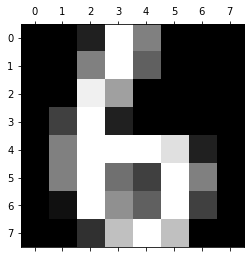

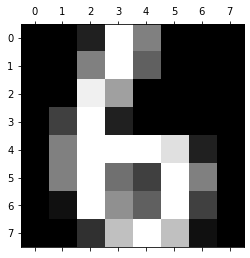

In [14]:
for i in range(len(X)):
    # print a poisoned image
    if not (X_train[i] == X_train_p[i]).all():
        print(X_train[i] - X_train_p[i], y_train[i], y_train_p[i])
        plt.matshow(X_train[i].reshape(8,8))
        plt.matshow(X_train_p[i].reshape(8,8))
        plt.show()
        break

In [15]:
nb_classes = np.unique(y_train_p).shape[0]
print(np.unique(y_train_p))
print(X_train_p.shape, X_test.shape)

[0 1 2 3 4 5 6 7 8 9]
(1437, 64) (360, 64)


In [16]:
model_p = SVC(C=1.0, kernel="rbf").fit(X_train_p, y_train_p)
accuracy = evaluateModel(model_p, X_test, y_test)
print("Accuracy on poisoned test examples: {:.2f}%".format(accuracy * 100))

Accuracy on poisoned test examples: 98.61%


### PoisoningAttackSVM (whitebox)

paper: https://arxiv.org/pdf/1206.6389.pdf

In [ ]:
from art.estimators.classification import SklearnClassifier

model = SVC(C=1.0, kernel="rbf").fit(X_train, y_train)

# Create the ART classifier
classifier = SklearnClassifier(model=model, clip_values=(np.amin(X), np.amax(X)))

In [ ]:
# Transform class labels to be one-hot-encoded of shape (nb_samples, nb_classes).
def convertToOnehot(labels, nb_classes):
    onehot = []
    for y in labels:
        vec = np.zeros(nb_classes)
        vec[y] = 1
        onehot.append(vec)
    return np.array(onehot)

y_train_onehot = convertToOnehot(y_train, nb_classes)
y_test_onehot = convertToOnehot(y_test, nb_classes)

In [ ]:
y_train_onehot.shape

(1437, 10)

In [ ]:
# Warning: This runs super slow (8 minutes per attack point)
from art.attacks.poisoning import PoisoningAttackSVM

attack_svm = PoisoningAttackSVM(classifier=classifier, step=2, eps=3, max_iter=3,
                                x_train=X_train, y_train=y_train_onehot, x_val=X_test, y_val=y_test_onehot)
attack_points = np.random.randint(len(X_train), size=100)
X_poisoned_svm, y_poisoned_svm = attack_svm.poison(x=X_train[attack_points], y=y_train_onehot[attack_points])


SVM poisoning: 0it [00:00, ?it/s]
SVM poisoning: 1it [07:39, 459.07s/it]
SVM poisoning: 2it [10:11, 367.16s/it]
SVM poisoning: 3it [17:47, 393.65s/it]
SVM poisoning: 4it [25:23, 412.52s/it]
SVM poisoning: 5it [32:58, 425.20s/it]
SVM poisoning: 6it [40:33, 434.12s/it]
SVM poisoning: 7it [48:07, 440.03s/it]
SVM poisoning: 8it [55:41, 444.34s/it]
SVM poisoning: 9it [1:03:16, 447.46s/it]
SVM poisoning: 10it [1:10:57, 451.39s/it]
SVM poisoning: 11it [1:13:29, 361.74s/it]
SVM poisoning: 12it [1:21:12, 392.14s/it]
SVM poisoning: 13it [1:28:48, 411.18s/it]
SVM poisoning: 14it [1:36:23, 424.36s/it]
SVM poisoning: 15it [1:38:54, 342.52s/it]
SVM poisoning: 16it [1:46:30, 376.34s/it]
SVM poisoning: 17it [1:54:04, 399.79s/it]
SVM poisoning: 18it [2:01:40, 416.64s/it]
SVM poisoning: 19it [2:04:12, 337.25s/it]
SVM poisoning: 20it [2:11:53, 374.40s/it]
SVM poisoning: 21it [2:14:26, 308.00s/it]
SVM poisoning: 22it [2:22:10, 354.64s/it]
SVM poisoning: 23it [2:29:46, 384.99s/it]
SVM poisoning: 24it [2:3

In [ ]:
with open(dir + 'X_poisoned_svm.npy', 'wb') as f:
    np.save(f, X_poisoned_svm)
with open(dir + 'y_poisoned_svm.npy', 'wb') as f:
    np.save(f, y_poisoned_svm)

In [ ]:
attack_points

array([750])

In [ ]:
X_train[attack_points] - X_poisoned_svm[0]

array([[ 0.00000000e+00, -9.46940630e-03, -1.39526924e-01,
        -1.29642128e-01,  1.33288246e-01,  2.96302121e-03,
        -3.73734909e-02, -3.89316402e-03, -3.11936214e-04,
        -5.63576815e-02, -1.39662577e-01,  1.13415764e-01,
        -5.00379655e-02, -1.92030986e-01, -5.79213480e-02,
        -5.16002635e-03, -3.46119066e-07, -1.87646354e-02,
         1.54521678e-01,  9.48180495e-02, -2.47817498e-01,
        -1.22467818e-01, -5.73551140e-03, -2.02843763e-03,
         0.00000000e+00,  1.40295654e-01,  2.31426339e-01,
        -1.64933595e-01, -3.21002293e-01,  1.86057738e-01,
         2.41332628e-01, -1.85979550e-04,  0.00000000e+00,
         2.84611818e-01,  2.65942373e-01, -8.67233400e-02,
        -3.53522137e-02,  2.19130805e-01,  2.76997704e-02,
         0.00000000e+00, -1.85652114e-04,  2.98832929e-02,
         1.84421702e-01,  1.47443452e-01,  1.44907539e-01,
         1.08047406e-01, -4.70382270e-02, -2.59325124e-04,
        -1.21947539e-03, -2.04928027e-02, -1.66749882e-0

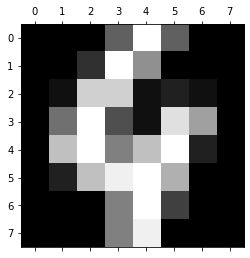

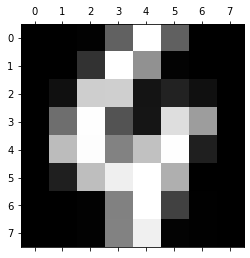

In [ ]:
plt.matshow(X_train[attack_points].reshape(8,8))
plt.matshow(X_poisoned_svm[0].reshape(8,8))